[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/tp/01_aprendizaje_supervisado/tp01-enunciado.ipynb)

# Trabajo Práctico -  Aprendizaje supervisado
### Clasificación de expresiones genómicas

<span style="color: red;">**Fecha de entrega: Jueves 01 de mayo del 2025 - hasta las 17:00hs.**

<span style="color: red;">**Fecha de entrega intermedia: Jueves 17 de Abril del 2025 - hasta las 17:00hs.**
</span>

## Introducción

En el mundo actual, distintas disciplinas científicas empiezan, cada vez más, a interactuar con el fin de potenciar sus descubrimientos. En este caso dos grupos de investigación de [CONICET](https://www.conicet.gov.ar/) se embarcan en la combinación entre biología y informática para abordar la detección temprana y el pronóstico preciso de enfermedades como el cáncer. Este proyecto combina las tecnologías de secuenciación de nueva generación ([_NGS_](https://es.wikipedia.org/wiki/Secuenciaci%C3%B3n_paralela_masiva), por sus siglas en inglés) con la potencia de la inteligencia artificial. El enfoque se centra en un dataset único que abarca mediciones de [_ARN_](https://es.wikipedia.org/wiki/ARN_mensajero) de 200 [_genes_](https://es.wikipedia.org/wiki/Gen), recopiladas de pacientes con lesiones [_pre-tumorales_](https://en.wikipedia.org/wiki/Hyperplasia). Este conjunto de datos se convierte en una valiosa fuente de información para entender cómo las células en estado de hiperplasia pueden evolucionar hacia [_tumores malignos_](https://en.wikipedia.org/wiki/Neoplasm), una transformación que ha desconcertado a la ciencia durante décadas.

La hiperplasia, es un fenómeno en el que las células experimentan un crecimiento anormal y descontrolado, es un punto de partida crucial en nuestro análisis. ¿Cómo y por qué algunas células que experimentan hiperplasia se convierten en células cancerosas, mientras que otras no? Esta pregunta es el corazón de nuestra investigación. Para responderla se realizo un estudio donde se obtuvieron muestras de distintos tipos de hiperplasias de pacientes con antecedentes familiares y lesiones pre tumorales. Este grupo de pacientes, o cohorte, fue monitoreado periodicamente durante los siguientes 5 años buscando indicios de neoplasias o nuevas hiperplasias más agresivas. Con las muestras obtenidas en este estudio se realizo un [_biobanco_](https://en.wikipedia.org/wiki/Biobank) con las mediciones que habitualmente se hacen en la construccion de este tipo de [_plataformas_](https://xena.ucsc.edu/). Cada muestra fue etiquetada como **_buen pronostico_**, si no hubo indicios de nuevas hiperplasias o similares; contrariamente se etiquetaron como de **_mal pronostico_** si hubo una recaida.

Este trabajo se concentra en un panel de genes, especificamente en la expresion de 200 genes que se creen tienen un papel crucial en la transformacion tumoral y su etiqueta correspondiente.

En concreto:

Tendrán un archivo `.csv` en donde se almacenan:
  - una matriz de datos `X` de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$.
  - una columna llamada `target` que representa un vector de $500$ posiciones con dos posibles valores: `True` (ó 1, es decir, tiene buen pronostico) y `False` (ó 0, tiene mal pronostico).

Los datos están en esta [carpeta](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

Por otra parte, tendrán disponibles un conjunto de instancias sin etiquetas, que utilizaremos para comprobar la calidad de sus resultados (ver Ejercicio 5).

**Recomendamos fuertemente leer primero todo el enunciado del trabajo antes de empezar a trabajar sobre el problema propuesto.**

---

### Sobre el informe

Para este trabajo deberán entregar, además del código de las pruebas y experimentos que realicen, un informe en el que deberan seleccionar, para cada apartado, sus resultados acompañado de un texto que explique, reflexione, justifique y conluya dicho contenido.

Cada ejercicio indica el largo máximo del texto que se puede incluir. Los gráficos no están contados en dicho espacio.
Cada gráfico incluido debe contar con:
  
  - nombres de los ejes,
  - título,
  - leyenda autocontenida,
  - debe ser referenciado desde el texto, ya que su inclusión se da porque aporta a la discusión del trabajo.

**El informe no puede superar un máximo de 8 carillas (contando gráficos) o 4 hojas más carátula.** Tamaño de la letra: estandár de latex (10pt). No se corregirán trabajos que no cumplan con esta consigna.

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from prettytable import PrettyTable
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid, RandomizedSearchCV, LearningCurveDisplay, ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

np.random.seed(42)

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos.

Evaluar y justificar cómo separarán sus datos para desarrollo y para evaluación. ¿Qué consideraciones tuvieron en cuenta para realizar esta división?

**Importante**: en este punto no está permitido dividir la base de datos utilizando la función `train_test_split` de sklearn. Deben decidir e implementar la separación.

### Resolución

Para separar los datos en sets de entrenamiento y evaluación analicemos primero las proporciones de la variable `target`, ya que si el dataset está desbalanceado será necesario hacer una divisón estratificada.

In [3]:
df = pd.read_csv("data.csv")

class_counts = df['target'].value_counts(normalize=True)
class_counts

,proportion
target,
0,0.698
1,0.302


Vemos que están desbalanceados, con lo cual vamos a proceder a hacer una división del dataset que tenga en cuenta este desbalance y así nos queden conjuntos de train y test bien estratificados (sino corremos el riesgo de que todo nuestro conjunto de testeo contenga solo 1 clase)



---



In [4]:
negative_class_df = df[df['target'] == 0].reset_index(drop=True)
positive_class_df = df[df['target'] == 1].reset_index(drop=True)

negative_class_df = negative_class_df.sample(frac=1)
positive_class_df = positive_class_df.sample(frac=1)

def split_train_test(df_clase, train_frac = 0.9):
    n = len(df_clase)
    train_end = int(train_frac * n)
    train = df_clase[:train_end]
    test = df_clase[train_end:]
    return train, test

train_0, test_0 = split_train_test(negative_class_df)
train_1, test_1 = split_train_test(positive_class_df)
Una
train_df = pd.concat([train_0, train_1]).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([test_0, test_1]).sample(frac=1).reset_index(drop=True)

proportions_simple = {
    "train": train_df['target'].value_counts(normalize=True),
    "test":  test_df['target'].value_counts(normalize=True)
}

proportions_simple

{'train': target
 0    0.699332
 1    0.300668
 Name: proportion, dtype: float64,
 'test': target
 0    0.686275
 1    0.313725
 Name: proportion, dtype: float64}

Lo que hicimos en el código anterior fue:

1- **Configurar el porcentaje** del dataset que usamos para entrenar y el que nos reservamos para testear nuestro(s) modelo(s) final(es).

2- **Tomar las muestras** negativas (target = 0) y las positivas (target = 1) y mezclarlas.

3- **Separar en train y test** cada una de las listas de muestras teniendo en cuenta i. el porcentaje train-test ii. teniendo en cuenta las proporciones calculadas previamente.

4- **Combinar** las muestras de train de cada clase y las de test.


---

## Definimos nuestro dataset

In [5]:
X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]

X_test = test_df.drop(columns=["target"])
y_test = test_df["target"]

## Ejercicio 2


### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo **árbol de decisión**. Además, obtener una **estimación realista de la performance** de los mismos.

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default.

1. Estimar la performance del modelo utilizando _K-fold cross validation_ con `K=5`, con las métricas _Accuracy_, _Area Under the Precision-Recall Curve (AUPRC)_, y _Area Under the Receiver Operating Characteristic Curve (AUCROC)_.

   En esta oportunidad se va a pedir además de calcular las métricas para cada fold por separado y su promedio, que hagan el cálculo del score global (como vimos en clase), sólo para los folds de validación.
   
   Reportar el resultado en una tabla similar a:

      <table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUPRC (training)</th>
      <th>AUPRC (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr>
      <td align="center">1</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">Promedios</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <td align="center">Global</td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      </tr>
      </tbody>
      </table>    
  
   **Importante**: de acá en más sólamente utilizaremos el score promedio cuando hagamos _K-fold cross-validation_.

1. Explorar las siguientes combinaciones de parámetros para  árboles de decisión (siguiendo con $k-fold$ con $k=5$) utilizando [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) de _scikit learn_. No está permitido utilizar `GridSearchCV` en este ejercicio.

   <table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   </tbody></table>

1. ¿Qué conclusiones se pueden sacar de estas tablas?  

### 2.1

In [6]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

Definimos nuestro arbol de decisión con los parametros indicados.

### 2.2

In [7]:
def k_fold_training(X, y, model, k = 5):
  train_accuracy_scores = []
  train_auprc_scores = []
  train_aucroc_scores = []

  val_accuracy_scores = []
  val_auprc_scores = []
  val_aucroc_scores = []

  all_y_true = []
  all_y_proba = []
  folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

  for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
      X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
      y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

      model.fit(X_train, y_train)

      y_train_pred = model.predict(X_train)
      y_train_proba = model.predict_proba(X_train)[:, 1]

      y_val_pred = model.predict(X_val)
      y_val_proba = model.predict_proba(X_val)[:, 1]

      train_acc = accuracy_score(y_train, y_train_pred)
      train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
      train_auprc = auc(train_recall, train_precision)
      train_aucroc = roc_auc_score(y_train, y_train_proba)

      val_acc = accuracy_score(y_val, y_val_pred)
      val_precision, val_recall, _ = precision_recall_curve(y_val, y_val_proba)
      val_auprc = auc(val_recall, val_precision)
      val_aucroc = roc_auc_score(y_val, y_val_proba)

      train_accuracy_scores.append(train_acc)
      train_auprc_scores.append(train_auprc)
      train_aucroc_scores.append(train_aucroc)

      val_accuracy_scores.append(val_acc)
      val_auprc_scores.append(val_auprc)
      val_aucroc_scores.append(val_aucroc)

      all_y_true.extend(y_val)
      all_y_proba.extend(y_val_proba)

  return {
      "train_accuracy_scores": train_accuracy_scores,
      "train_auprc_scores": train_auprc_scores,
      "train_aucroc_scores": train_aucroc_scores,
      "val_accuracy_scores": val_accuracy_scores,
      "val_auprc_scores": val_auprc_scores,
      "val_aucroc_scores": val_aucroc_scores,
      "all_y_true": all_y_true,
      "all_y_proba": all_y_proba
    }

Para resolver el inciso 2 y el 3 **definimos una función** que toma como parámetros:

1. X features

2. y columna target

3. model, el Modelo a entrenar

4. k, la cantidad de folds para realizar la validación cruzada


Finalmente ejecutamos un **Strattified K-fold** sobre nuestros datos y calculamos las métricas indicadas en la consigna


---



In [8]:
k = 5
train_acc_scores, \
train_auprc_scores, \
train_aucroc_scores, \
val_acc_scores, \
val_auprc_scores, \
val_aucroc_scores, \
all_y_true, \
all_y_proba = k_fold_training(X_train, y_train, tree_model, k).values()

avg_train_acc = np.mean(train_acc_scores)
avg_train_auprc = np.mean(train_auprc_scores)
avg_train_aucroc = np.mean(train_aucroc_scores)

avg_val_acc = np.mean(val_acc_scores)
avg_val_auprc = np.mean(val_auprc_scores)
avg_val_aucroc = np.mean(val_aucroc_scores)

precision_global, recall_global, _ = precision_recall_curve(all_y_true, all_y_proba)
global_auprc = auc(recall_global, precision_global)
global_aucroc = roc_auc_score(all_y_true, all_y_proba)
global_accuracy = accuracy_score(all_y_true, np.array(all_y_proba) > 0.5)

final_score_table = pd.DataFrame({
    "Permutación": [str(i + 1) for i in range(k)] + ["Promedios", "Global"],
    "Accuracy (training)": train_acc_scores + [avg_train_acc, "NO"],
    "Accuracy (validación)": val_acc_scores + [avg_val_acc, global_accuracy],
    "AUPRC (training)": train_auprc_scores + [avg_train_auprc, "NO"],
    "AUPRC (validación)": val_auprc_scores + [avg_val_auprc, global_auprc],
    "AUC ROC (training)": train_aucroc_scores + [avg_train_aucroc, "NO"],
    "AUC ROC (validación)": val_aucroc_scores + [avg_val_aucroc, global_aucroc]
})

final_score_table

,Permutación,Accuracy (training),Accuracy (validación),AUPRC (training),AUPRC (validación),AUC ROC (training),AUC ROC (validación)
0,1,0.805014,0.722222,0.740471,0.406262,0.805279,0.645209
1,2,0.777159,0.622222,0.754101,0.361583,0.838129,0.631393
2,3,0.810585,0.711111,0.703889,0.439166,0.820828,0.642563
3,4,0.807799,0.588889,0.669512,0.345945,0.836118,0.523810
4,5,0.836111,0.707865,0.708501,0.414424,0.789701,0.652330
5,Promedios,0.807334,0.670462,0.715295,0.393476,0.818011,0.619061
6,Global,NO,0.670379,NO,0.384916,NO,0.632779


### 2.3

In [9]:
parameters_grid = [
    {'max_depth': [3, 5, None], 'criterion': ['gini', 'entropy']},
]

rows = []

for parameters in ParameterGrid(param_grid=parameters_grid):
    model = DecisionTreeClassifier(**parameters)

    results = k_fold_training(X_train, y_train, model, k = 5)

    avg_train_acc = np.mean(results['train_accuracy_scores'])
    avg_val_acc = np.mean(results['val_accuracy_scores'])

    rows.append({
        'Altura máxima': parameters['max_depth'] or 'inf',
        'Criterio de corte': parameters['criterion'],
        'Accuracy (training)': avg_train_acc,
        'Accuracy (validación)': avg_val_acc
    })

table = pd.DataFrame(rows)
table

,Altura máxima,Criterio de corte,Accuracy (training),Accuracy (validación)
0,3,gini,0.807334,0.670462
1,5,gini,0.928737,0.670437
2,inf,gini,1.000000,0.672534
3,3,entropy,0.797331,0.690462
4,5,entropy,0.909810,0.634757
5,inf,entropy,1.000000,0.652684


Realizamos un grid search aprovechandonos de la clase **ParameterGrid** la cual nos facilita un producto cartesiano de los atributos que definimos en nuestro diccionario de parámetros.

Lo que se puede apreciar es que a medida que aumenta la *altura máxima* la *accuracy* en training aumenta (vemos que en altura_max = ∞ la accuracy es 1) pero la accuracy en validación no. Esto nos muestra que puede estar ocurriendo un sobreajuste en los datos. Luego, desde el criterio de corte, no se notaron diferencias significativas.

## Ejercicio 3

### Comparación de algoritmos

Se pide explorar distintas combinaciones de algoritmos de aprendizaje con diferentes configuraciones con el objetivo de **encontrar el mejor modelo** de cada familia de buscar la performance óptima. Para este ejercicio realizar una experimentación utilizando [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Como métrica de performance usar AUCROC resultante de 5-fold cross-validation.

Hiperparámetros_: Revisar la documentación de cada uno de los hiperparámetros para entender qué posibles hiperparámetros impacten de manera positiva en la construcción del algoritmo.

Documentación extra sobre [`Tuning hyper-parameters`](https://scikit-learn.org/stable/modules/grid_search.html), leer hasta 3.2.2.

1. Algoritmos a probar:
  - Árboles de decisión. Mínimo 4 hiperparámetros.
  - KNN (k-vecinos más cercanos). Mínimo 3 hiperparámetros.
  - SVM (Support vector machine). Mínimo 2 hiperparámetros.

Detallar los hiperparámetros elegidos para cada algoritmo y explicar la razón del espacio de búsqueda considerado para cada uno de estos, ¿cuántas iteraciones usaron?. A su vez, reportar la performance asociada de aquellos que consideren relevantes (al menos la mejor combinación para cada algoritmo).

2. Compare los resultados obtenidos en el ejercicio anterior con los siguientes modelos con sus hiperparámetros default.

  - LDA (Linear discriminant analysis)
  - Naïve Bayes

¿Qué resultados obtuvo? ¿Qué hiperparámetros podrían ser relevantes explorar en estos modelos? ¿Por qué?

3. ¿Cuál fue el mejor modelo y con qué configuración? Explicar por qué creería que dio mejor (recordando qué hace cada algoritmo y con qué tipo de datos están trabajando).

### 3.1.1 Arboles

In [10]:
parameters_grid = {
    'max_depth': list(range(1,51,1)) +[None],
    'criterion': ['gini', 'entropy',"log_loss"],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced'],
    'min_samples_split': np.arange(2, 101, 5),
    'min_samples_leaf': np.arange(1, 21, 5),
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.5],
    'max_leaf_nodes': np.concatenate([[None], np.arange(2, 101, 5)]),
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
}

tree_random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=parameters_grid,
    n_iter=1000,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring = 'roc_auc'
)

tree_random_search.fit(X_train, y_train)

print("Mejores parámetros:", tree_random_search.best_params_)
print("Mejor score:", tree_random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Mejores parámetros: {'splitter': 'random', 'min_weight_fraction_leaf': 0.05, 'min_samples_split': np.int64(52), 'min_samples_leaf': np.int64(11), 'max_leaf_nodes': 62, 'max_features': None, 'max_depth': 34, 'criterion': 'entropy', 'class_weight': 'balanced'}
Mejor score: 0.6821897934801161


Hiperparametros elegidos:

1. **max_depth:** Define la altura máxima que tendrá el arbol. Variar este parámetro nos ayuda a explorar arboles de diferente complejidad.

2. **criterion:** Define el criterio de corte de cada split. Variar este parámetro puede encontrar que un criterio ayuda a disminuir la entropía de una forma más eficiente.

3. **splitter:** Define si el split elegido será el óptimo, o dentro de los óptimos de cada clase, uno al azar. Explorar también la rama que elige al azar puede ayudar a encontrar arboles que sobreajusten menos a los datos, al no siempre elegir el mejor corte.

4. **min_samples_split:**: Especifica el número mínimo de muestras necesarias para dividir un nodo. Un valor bajo puede llevar a divisiones muy específicas y sobreajuste, mientras que un valor alto evita divisiones en nodos con pocas muestras, favoreciendo la generalización del modelo.


El número de iteraciones se definió en 100 para explorar varias combinaciones dentro de nuestro espacio (alrededor de un 20%)

### 3.1.2 SVM

In [23]:
parameters_grid = {
    'C': np.logspace(-4, 4, 20),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-6, 1, 20)),
    'degree': [2, 3, 4, 5, 6],
    'coef0': [0.0, 0.1, 0.5, 1.0],
    'class_weight': [None, 'balanced']
}


svm_random_search = RandomizedSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_distributions=parameters_grid,
    n_iter=1000,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring = "roc_auc",
)

svm_random_search.fit(X_train, y_train)

print("Mejores parámetros:", svm_random_search.best_params_)
print("Mejor score:", svm_random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Mejores parámetros: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'coef0': 1.0, 'class_weight': None, 'C': np.float64(206.913808111479)}
Mejor score: 0.9195027592877055


Hiperparametros elegidos:

1. **kernel:** Variar el kernel nos ayuda a explorar distintas formas de separar/representar al espacio transformado de nuestros datos (asi poder encontrar cuál separa mejor linealmente los mismos)

2. **C:** Es el parámetro de penalización que controla la tolerancia a errores. Ajustar este valor ayuda a encontrar un equilibrio entre un modelo que se ajusta demasiado a los datos y uno que generaliza mejor.

3. **gamma:** Ajusta el alcance de la influencia de cada punto de datos para el kernel gaussiano, lo que influye en la capacidad del modelo para adaptarse a patrones en los datos. Un valor mayor puede llevar a un modelo más complejo, mientras que un valor menor contribuye a una mayor generalización.

4. **degree:** Se aplica en kernels polinomiales y define el grado del polinomio. Un valor mayor aumenta la complejidad del modelo al permitir capturar interacciones de orden más alto, lo que puede mejorar el ajuste en ciertos casos pero también incrementar el riesgo de sobreajuste.

5. **coef0:** afecta el resultado del kernel 'poly' y 'sigmoid' agregando un término independiente; modifica la curvatura de la frontera.

6. **class_weight:** permite darle más importancia a una clase que a otra, útil si las clases están desbalanceadas.


### 3.1.3 KNN

In [26]:
parameters_grid = {
    'n_neighbors': np.arange(1, 100),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': list(range(3,11,1))
}

knn_random_search = RandomizedSearchCV(
    estimator= KNeighborsClassifier(),
    param_distributions=parameters_grid,
    n_iter=1000,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring = "roc_auc"
)

knn_random_search.fit(X_train, y_train)

print("Mejores parámetros:", knn_random_search.best_params_)
print("Mejor score:", knn_random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Mejores parámetros: {'weights': 'distance', 'p': 9, 'n_neighbors': np.int64(17), 'metric': 'manhattan'}
Mejor score: 0.8864368208454231


Hiperparametros elegidos:

1. **n_neighbors:** Define la cantidad de vecinos considerados para la votación de la clase. Variar este parámetro ayuda a balancear la varianza y el sesgo del modelo: más vecinos reducen la varianza, pero pueden aumentar el sesgo.

2. **weights:** Establece la forma de ponderar el voto de cada vecino. Usar ponderaciones, como "uniforme" o "distancia", puede mejorar el ajuste del modelo especialmente en espacios con muchas dimensiones.

3. **metric:** Determina la forma de medir la distancia entre observaciones. Evaluar diferentes métricas permite identificar cuál se ajusta mejor a la distribución y alta dimensionalidad del problema.

4. **p:** se usa solo con la métrica 'minkowski' y determina qué tan parecida es la distancia a la manhattan (p=1) o a la euclidiana (p=2).

### 3.1 Conclusiones

In [27]:
table = PrettyTable()
table.field_names = ["Modelo", "Score"]

table.add_row(["Árbol de Decisión", tree_random_search.best_score_])
table.add_row(["SVM", svm_random_search.best_score_])
table.add_row(["KNN", knn_random_search.best_score_])

print(table)

+-------------------+--------------------+
|       Modelo      |       Score        |
+-------------------+--------------------+
| Árbol de Decisión | 0.6821897934801161 |
|        SVM        | 0.9195027592877055 |
|        KNN        | 0.8864368208454231 |
+-------------------+--------------------+


Observamos que nuestro mejor modelo de SVM evaluado en nuestro conjunto reservado de datos le gana al resto de modelos.

### 3.2

In [28]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

k = 5
train_acc_scores, \
train_auprc_scores, \
train_aucroc_scores, \
val_acc_scores, \
val_auprc_scores, \
val_aucroc_scores, \
all_y_true, \
all_y_proba = k_fold_training(X_train, y_train, lda, k).values()

aucroc_lda = roc_auc_score(all_y_true, all_y_proba)

In [29]:
naive = GaussianNB()
naive.fit(X_train, y_train)

k = 5
train_acc_scores, \
train_auprc_scores, \
train_aucroc_scores, \
val_acc_scores, \
val_auprc_scores, \
val_aucroc_scores, \
all_y_true, \
all_y_proba = k_fold_training(X_train, y_train, naive, k).values()

aucroc_nb = roc_auc_score(all_y_true, all_y_proba)

Nuestra tabla actualizada:

In [30]:
table = PrettyTable()
table.field_names = ["Modelo", "Score"]

table.add_row(["Árbol de Decisión", tree_random_search.best_score_])
table.add_row(["SVM", svm_random_search.best_score_])
table.add_row(["KNN", knn_random_search.best_score_])
table.add_row(["LDA (default)", aucroc_lda])
table.add_row(["Naive Bayes (default)", aucroc_nb])

print(table)

+-----------------------+--------------------+
|         Modelo        |       Score        |
+-----------------------+--------------------+
|   Árbol de Decisión   | 0.6821897934801161 |
|          SVM          | 0.9195027592877055 |
|          KNN          | 0.8864368208454231 |
|     LDA (default)     | 0.7665723047888653 |
| Naive Bayes (default) | 0.7993866477942911 |
+-----------------------+--------------------+


Vemos que por lejos SVM sigue siendo la cabecera de la lista.

Estos son algunos de los hiperparametros que se podrían ajustar en LDA: el solver, y el shrinkage. Ambos tienen que ver con la forma computacional en la que se calcula o se estima la matriz de covarianza (pieza fundamental del modelo)

## Ejercicio 4
### Diagnóstico Sesgo-Varianza.

<span style="color: red;">(no realizar hasta la clase _Sesgo y Varianza_)</span>

En este punto, se pide inspeccionar **tres** de sus mejores modelos encontrados hasta ahora de cada familia de modelos: la mejor configuración para el árbol de decisión y la mejor configuración para SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo pero ahora incluya LDA. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo **RandomForest** con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.


**Atención**: Tener en cuenta que debemos seguir utilizando AUC ROC como métrica para estas curvas.


### 4.1

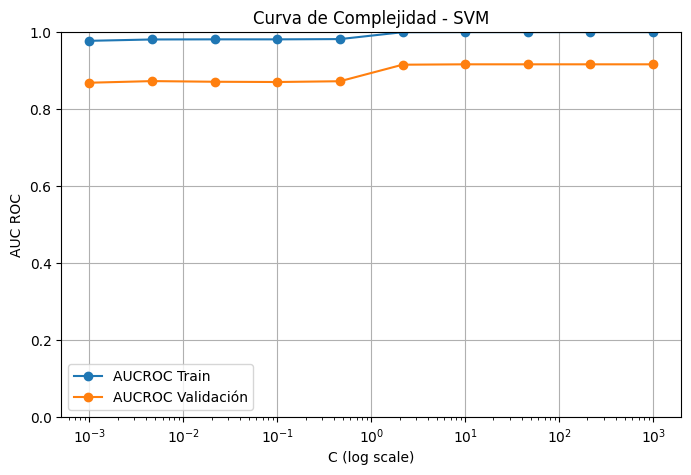

In [31]:
# Curvas de complejidad SVM
best_svm_params = svm_random_search.best_params_.copy()
best_svm_params.pop('C')

# Valores de C que vamos a probar
C_values = np.logspace(-3, 3, 10)
train_scores_svm = []
val_scores_svm = []

for C in C_values:
    svm = SVC(C=C, probability=True, **best_svm_params, random_state=42)
    resultados = k_fold_training(X_train, y_train,svm,5)
    train_auc = np.mean(resultados["train_aucroc_scores"])
    val_auc = np.mean(resultados["val_aucroc_scores"])
    train_scores_svm.append(train_auc)
    val_scores_svm.append(val_auc)

plt.figure(figsize=(8,5))
plt.plot(C_values, train_scores_svm, label='AUCROC Train', marker='o')
plt.plot(C_values, val_scores_svm, label='AUCROC Validación', marker='o')
plt.xscale('log')
plt.ylim(0,1)
plt.xlabel('C (log scale)')
plt.ylabel('AUC ROC')
plt.title('Curva de Complejidad - SVM')
plt.legend()
plt.grid()
plt.show()


Podemos observar en el gráfico que, al tomar la mejor combinación de hiperparámetros y variar únicamente el valor de C, se produce un salto en la complejidad del modelo a partir de C ≈ 2.15. Sin embargo, en la búsqueda realizada, la mejor combinación reportada por RandomizedSearchCV utilizó un valor de C ≈ 46.42.

Al analizar en detalle las combinaciones de hiperparámetros probadas durante la búsqueda, encontramos que no se evaluó la opción de C ≈ 2.15 junto con el resto de los mejores hiperparámetros encontrados.

Como conclusión, encontramos una mejor combinación de hiperparámetros (con C ≈ 2.15) que la propuesta inicialmente por RandomizedSearchCV (con C ≈ 46.42).

In [32]:
# Accedemos a todos los parámetros probados
all_params = svm_random_search.cv_results_['params']

# Filtramos los que tengan C entre 2 y 3
filtered_params = [p for p in all_params if 2 <= p['C'] <= 3]
for params in filtered_params:
    print(params)

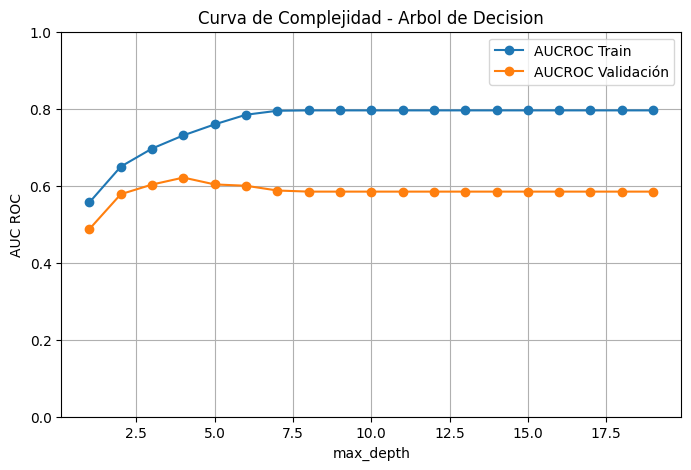

In [33]:
# Curvas de complejidad Arbol Decision
best_tree_params = tree_random_search.best_params_.copy()
best_tree_params.pop('max_depth')

max_depth_values = list(np.arange(1, 20))
train_scores_tree = []
val_scores_tree = []

for max_depth in max_depth_values:
    tree = DecisionTreeClassifier(max_depth=max_depth,**best_tree_params,random_state=42)
    resultados = k_fold_training(X_train, y_train,tree,5)
    train_auc = np.mean(resultados["train_aucroc_scores"])
    val_auc = np.mean(resultados["val_aucroc_scores"])
    train_scores_tree.append(train_auc)
    val_scores_tree.append(val_auc)

plt.figure(figsize=(8,5))
plt.plot(max_depth_values, train_scores_tree, label='AUCROC Train', marker='o')
plt.plot(max_depth_values, val_scores_tree, label='AUCROC Validación', marker='o')
plt.xlabel('max_depth')
plt.ylabel('AUC ROC')
plt.ylim(0, 1)
plt.title('Curva de Complejidad - Arbol de Decision')
plt.legend()
plt.grid()
plt.show()


### 4.2

In [34]:
# SVM
svm = SVC(probability=True, **best_svm_params, random_state=42)
# Decision Tree
tree = DecisionTreeClassifier(**best_tree_params, random_state=42)
# LDA
lda = LinearDiscriminantAnalysis()

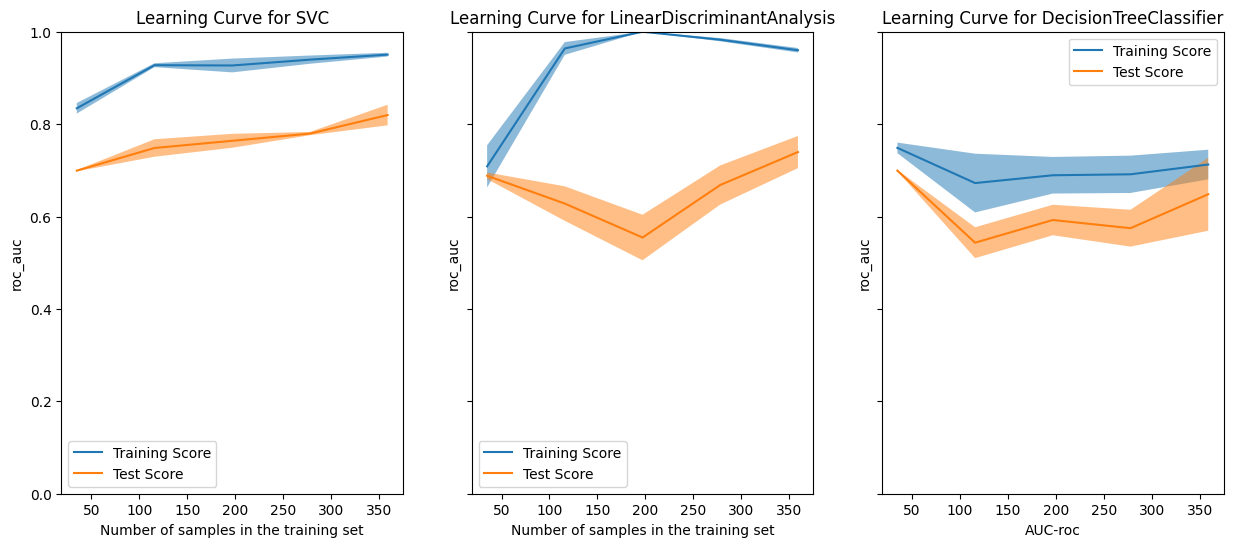

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

for ax_idx, estimator in enumerate([svm, lda, tree]):
    LearningCurveDisplay.from_estimator(estimator, X=X_train, y=y_train , ax=ax[ax_idx], score_name = "roc_auc")
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    plt.xlabel("AUC-roc")
    plt.ylim(0, 1)

#### En SVM y LDA es clara la tendencia creciente del AUC en ambos sets: cuanto más grande es el dataset de enternamiento, mayor es la performance.


### 4.3

In [37]:
rf = RandomForestClassifier(n_estimators=200)

k = 5
train_acc_scores, \
train_auprc_scores, \
train_aucroc_scores, \
val_acc_scores, \
val_auprc_scores, \
val_aucroc_scores, \
all_y_true, \
all_y_proba = k_fold_training(X_train, y_train, rf, k).values()

train_auc = np.mean(train_aucroc_scores)
test_auc = np.mean(val_auprc_scores)

print('AUC train set:',train_auc)
print('AUC test set:',test_auc)

AUC train set: 1.0
AUC test set: 0.6431509290370407


In [38]:
max_features1 = list(range(1, 20)) + list(range(21, 200, 15))

train_scores_random1 = []
val_scores_random1 = []

for max_feature1 in max_features1:
    rf1 = RandomForestClassifier(n_estimators=200,max_features=max_feature1,random_state=42)
    resultados1 = k_fold_training(X_train, y_train,rf1,5)
    train_auc1 = np.mean(resultados1["train_aucroc_scores"])
    val_auc1 = np.mean(resultados1["val_aucroc_scores"])
    train_scores_random1.append(train_auc1)
    val_scores_random1.append(val_auc1)

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(max_features1, train_scores_random1, label='AUCROC Train', marker='o')
plt.plot(max_features1, val_scores_random1, label='AUCROC Validación', marker='o')
plt.ylim(0,1)
plt.xlabel('max features')
plt.ylabel('AUC ROC')
plt.title('Curva de Complejidad - Random Forest')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

Como desarrollamos en el informe, quisimos probar si un "mal modelo" (hiperparámetros que sobre o sub ajusten) tendrían impacto en nuestra curva de complejidad, por lo que mediante RandomizedSearch buscamos los mejores parámetros posibles para hacer variar el max_features.


**Aclaración**: Por cuestiones de tiempo las siguientes celdas que fueron un experimento nuestro, no llegaron a ser corridas en la versión final. De todas formas se pueden correr y ver los resultados plasmados en el informe.

In [ ]:
# Grid de parámetros válido para Random Forest
parameters_grid = {
    'n_estimators': [200],
    'max_depth': list(range(1, 51)) + [None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': np.arange(2, 101, 5),
    'min_samples_leaf': np.arange(1, 21, 5),
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.5],
    'max_leaf_nodes': np.concatenate([[None], np.arange(2, 101, 5)]),
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
}

# Randomized Search con Random Forest
forest_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=parameters_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Entrenamiento
forest_random_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", forest_random_search.best_params_)
print("Mejor score:", forest_random_search.best_score_)


In [ ]:
best_forest_random_search_params = forest_random_search.best_params_.copy()
best_forest_random_search_params.pop('max_features')
max_features = list(range(1, 20)) + list(range(21, 200, 15))

train_scores_random = []
val_scores_random = []

for max_feature in max_features:
    rf = RandomForestClassifier(**best_forest_random_search_params ,max_features=max_feature, random_state=42)
    resultados = k_fold_training(X_train, y_train,rf,5)
    train_auc = np.mean(resultados["train_aucroc_scores"])
    val_auc = np.mean(resultados["val_aucroc_scores"])
    train_scores_random.append(train_auc)
    val_scores_random.append(val_auc)

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(max_features, train_scores_random, label='AUCROC Train', marker='o')
plt.plot(max_features, val_scores_random, label='AUCROC Validación', marker='o')
plt.ylim(0,1)
plt.xlabel('Máxima cantidad de features')
plt.ylabel('AUC ROC')
plt.title('Curva de Complejidad - Random Forest con los mejores parámetros')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(max_features, train_scores_random, label='AUCROC Train', marker='o')
plt.plot(max_features, val_scores_random, label='AUCROC Validación', marker='o')
plt.ylim(0,1)
plt.xlabel('Máxima cantidad de features')
plt.ylabel('AUC ROC')
plt.title('Curva de Complejidad - Random Forest con los mejores parámetros')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

El parámetro `max_features` de `RandomForestClassifier` determina cuántas variables se seleccionan aleatoriamente para evaluar en cada división de los árboles del bosque. Cuanto menor el valor, mayor la diversidad entre árboles; cuanto mayor, más se parece cada árbol a un árbol de decisión tradicional.

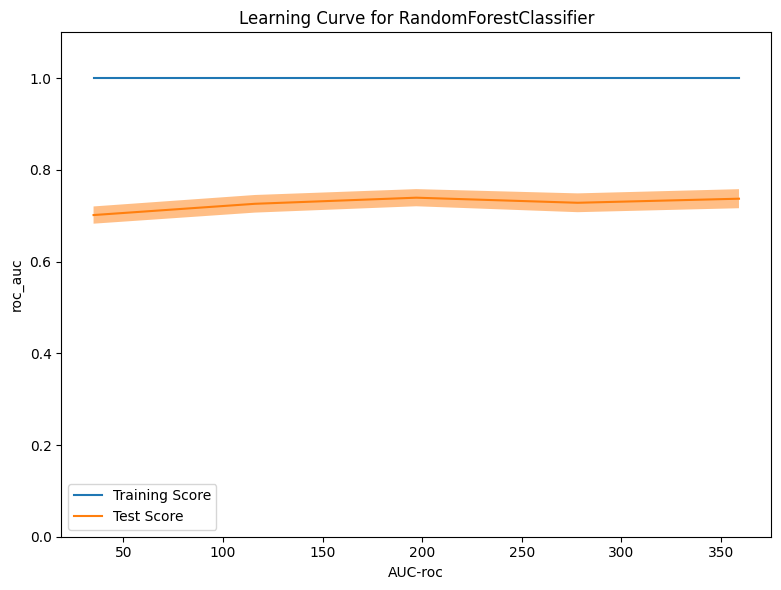

In [41]:
random_forest = RandomForestClassifier(n_estimators=200, max_features=199, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))

LearningCurveDisplay.from_estimator(random_forest, X=X_train, y=y_train, ax=ax, score_name = "roc_auc")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {random_forest.__class__.__name__}")
plt.xlabel("AUC-roc")
plt.tight_layout()
plt.ylim(0, 1.1)
plt.show()


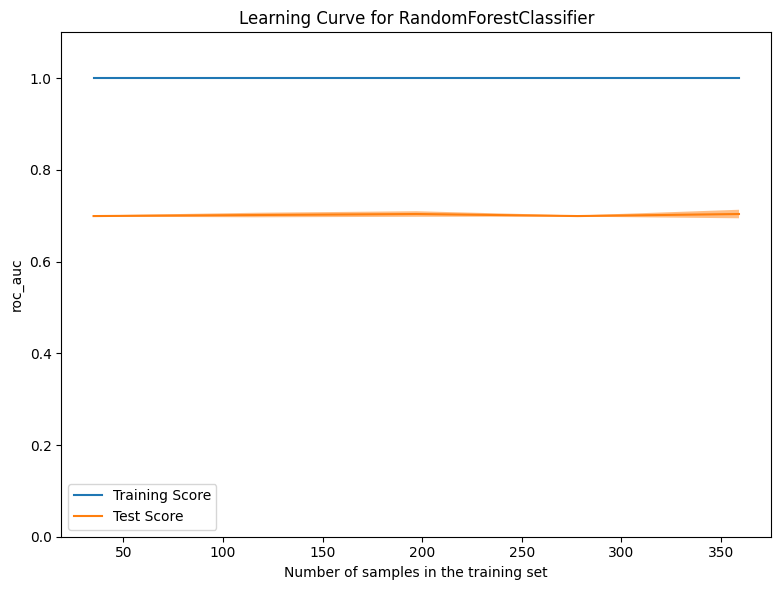

In [42]:
random_forest = RandomForestClassifier(n_estimators=200, max_features=8, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))

LearningCurveDisplay.from_estimator(random_forest, X=X_train, y=y_train, ax=ax, score_name = "roc_auc")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {random_forest.__class__.__name__}")

plt.tight_layout()
plt.ylim(0, 1.1)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

LearningCurveDisplay.from_estimator(forest_random_search, X=X_train, y=y_train, ax=ax, score_name = "roc_auc")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {random_forest.__class__.__name__}")

plt.tight_layout()
plt.ylim(0, 1.1)
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
plt.figure(figsize=(13,5))
plt.plot(max_features, train_scores_random, label='AUCROC Train', marker='o')
plt.plot(max_features, val_scores_random, label='AUCROC Validación', marker='o')
plt.ylim(0,1)
plt.xlabel('Máxima cantidad de features')
plt.ylabel('AUC ROC')
plt.title('Curva de Complejidad - Random Forest con los mejores parámetros')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
df=X_train
feature_importances = pd.Series(model.feature_importances_, index=df.columns)

top_features = feature_importances.sort_values(ascending=False).head(10).index

df_top = df[top_features]

corr_matrix = df_top.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación de las 10 variables más importantes")
plt.tight_layout()
plt.show()

De yapa estudiamos la matriz de correlación :p

## Ejercicio 5:
### Evaluación de performance

- La entrega del trabajo estará acompañada de una evaluación en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados.

- Su tarea será estimar la performance (AUCROC) que tendrá su mejor modelo en datos de evaluación (X_held_out).

- Para ello, deberán predecir las **probabilidades** de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUCROC resultante y calcularemos el resultado real. Consideraremos que el **mejor modelo será el que se encuentre más cerca del valor real que calcularemos luego de la entrega**.

- Recomendamos no perder de vista esta evaluación/competencia durante el desarrollo del TP, sobretodo en el momento de separar los datos en los primeros puntos.

- Para que podamos evaluar la performance, junto con la entrega del informe, deberán enviar un archivo con el numero de grupo con dos digitos en formato csv con la columna `output` y el valor obtenido con 4 decimales (se subirá un ejemplo cuando se publiquen los datos de la competencia) y un valor esperado de AUCROC: `GG_y_pred_held_out_AUCROC`.

    - Ej.: el grupo tres cree que obtuvo un valor de 0.7321 de AUCROC deberá submitear un archivo llamado: `03_y_pred_held_out_7321.csv`.

- Los datos podrán encontrarlos en este [link](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

- Las decisiones de este punto pueden desarrollarse hasta en una carilla, aunque con media debería alcanzar.


In [25]:
X_held_out = pd.read_csv('X_held_out.csv')

y_pred_proba = svm_random_search.predict_proba(X_held_out.values)[:, 1]

output_df = pd.DataFrame({
    'output': y_pred_proba
})

grupo = "02"
y_test_proba = svm_random_search.predict_proba(X_test)[:, 1]
aucroc_estimado = roc_auc_score(y_test, y_test_proba)

nombre_archivo = f"{grupo}_y_pred_held_out_{str(round(aucroc_estimado, 4)).replace('.', '')[1:]}.csv"

output_df.to_csv(nombre_archivo, index=False)
print(f"La performance de AUC obtenida es: {round(aucroc_estimado, 4)}")
print(f"Archivo {nombre_archivo} generado correctamente.")

0.9267857142857143
Archivo 02_y_pred_held_out_9268.csv generado correctamente.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Ejercicio 6:
### Conclusiones

Escribir como mínimo en un párrafo, una conclusión del trabajo realizado, incluyendo problemas encontrados y
aspectos no incluidos en el enunciado que hayan sido abordadas durante el desarrollo.

---
## Entregables
- Contarán con un esqueleto en formato Jupyter Notebook en donde podrán intercalar celdas para reportar y responder a los ítems de cada ejercicio.
- Los entregrables serán
    - Un informe en formato .pdf (**digital**) que responda a los ítems de este enunciado respetando la cantidad de espacio máximo por cada ítem. Nombrarlo siguiendo el formato `GG_Nombre_de_grupo`
    - Adjuntar el notebook final en formatos .pdf e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (verificarlo haceindo: Kernel -> Restart and Run All).
    - Las predicciones del *held out* del punto 5 en formato csv.
- Habŕa una entrega intermedia obligatoria que deberán hacer antes del 17 de abril de 2025 a las 17:00hs. Para esta entrega deberán enviar el código que resuelve los primeros 3 ejercicios.
- La **fecha** y **hora límite** de entrega está determinada en el campus de la materia.
- El trabajo deberá elaborarse en grupos de 5 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.


### Importante: sobre el uso de ChatGPT y grandes modelos de lenguaje

En este trabajo no estará explícitamente prohibido pero si fuertemente desaconsejado, consideramos a este trabajo práctico una importante herramienta de aprendizaje donde el uso de GPT puede ser perjudicial. En caso de usarlo se pide aclararlo en el informe y especificar cómo y en donde se utilizó. Así como expresar su opinión sobre la respuesta generada por el modelo pudiendo estar a favor o en contra de lo propuesto por este. Pueden adjuntar el link a la conversación con el modelo.

**Nota**: Agradecemos a [Martín García Sola](https://ar.linkedin.com/in/martin-e-garcia-sola) por la asistencia biológica en la confección de este Trabajo Práctico.